<a href="https://colab.research.google.com/github/Nathan2605/Bankruptcy-Colombia-nh/blob/main/Colombia_Bankruptcy_predictive_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tableone
!pip install seaborn
!pip install imbalanced-learn > null

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree


from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier


from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from tableone import TableOne, load_dataset
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix, precision_score, recall_score, roc_auc_score
from sklearn.metrics import roc_curve, auc

###data

In [3]:
df = pd.read_csv('train (2).csv')

In [4]:
df.head(3)

,index,Ganancia bruta,Ganancia (pérdida),Ingresos de actividades ordinarias,Costo de ventas,Patrimonio total,Total pasivos,Total de activos,Ganancias acumuladas,Pasivos corrientes totales,Activos corrientes totales,Sector,event
0,7620,3.218247e+05,1322028.0,3.218247e+05,NaN,9.147743e+06,97298.0,9.245041e+06,2610498.0,97298.0,3207644.0,L,0.0
1,17602,1.665600e+05,-160393.0,1.665600e+05,NaN,3.594330e+05,64899.0,4.243320e+05,-160393.0,64899.0,193787.0,G,0.0
2,18421,2.387397e+06,380574.0,3.686907e+06,1299510.0,2.421259e+06,2945965.0,5.367224e+06,461980.0,1615549.0,3364490.0,J,0.0


In [5]:
def is_binary(df_, nums):
    df = df_.copy()
    variables = []
    for var in nums:
        flag = True
        unique = df_[var].unique()
        for value in unique:
            if value not in [0, 1, np.nan, 0.0, 1.0]:
                flag = False
        if flag == True:
            variables.append(var)
    return variables

def breakdown_vars(df, off_binary=False):
    """
    This function allow us categorize accodign to numerical or not
    """
    binaries = is_binary(df, df.columns)
    categorial = []
    nonormal = []
    normal = []
    for t in df.columns:
        if off_binary == False:
          if (df[t].dtypes.name=="object" or df[t].dtypes.name=='category') and  t not in binaries:
            categorial.append(t)
        else:
           if (df[t].dtypes.name=="object" or df[t].dtypes.name=='category'):
            categorial.append(t)
        if (df[t].dtypes=="int64" or df[t].dtypes=="float64") and t not in binaries:
                n,p = stats.shapiro(df[t])
                if p<0.05:
                    nonormal.append(t)
                else:
                    normal.append(t)
    if off_binary == False:
      return categorial, binaries, nonormal, normal
    else:
      return categorial, nonormal, normal

def normalize(array):
  return (array - array.mean())/array.std()


def clean(df):
    # tener en cuenta...
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)
    return df[indices_to_keep].astype(np.float64)

In [6]:
#factorizar
df['Sector'] = pd.factorize(df['Sector'])[0]

#drop
df = df.drop(columns=['Costo de ventas']) #muchos Nan

#input Nan
df['Ganancias acumuladas'] = df['Ganancias acumuladas'].fillna(df['Ganancias acumuladas'].mean())
df['Pasivos corrientes totales'] = df['Pasivos corrientes totales'].fillna(df['Pasivos corrientes totales'].mean())
df['Activos corrientes totales'] = df['Activos corrientes totales'].fillna(df['Activos corrientes totales'].mean())

#ratios
df['ROA']=df['Ganancia (pérdida)']/df['Total de activos']
df['ROE']=df['Ganancia (pérdida)']/df['Patrimonio total']
df['DR']=df['Total pasivos']/df['Total de activos']
df['DC']=df['Pasivos corrientes totales']/df['Total pasivos']
df['WCR']=df['Activos corrientes totales']/df['Pasivos corrientes totales']

##df['LTD/E']=df['Total pasivos']/df['Patrimonio total']
##df['RP'] = df['Ganancia bruta'] / df['Patrimonio total']
##df['Ax1'] = (df['Activos corrientes totales'] - df['Pasivos corrientes totales'])/df['Total de activos']
##df['Ax2'] = (df['Ganancias acumuladas'] / df['Total de activos'])
##df['SRA'] = df['Pasivos corrientes totales'] / df['Patrimonio total']         ...ratios que generan colinealidad


#datos
features = ['Sector', 'ROA', 'ROE', 'DR', 'DC', 'WCR', 'event']
df = df[features]

#limpiar
df = clean(df)
df = df.dropna()

In [7]:
df.head(3)

,Sector,ROA,ROE,DR,DC,WCR,event
0,0.0,0.142999,0.144520,0.010524,1.000000,32.967214,0.0
1,1.0,-0.377989,-0.446239,0.152944,1.000000,2.985978,0.0
2,2.0,0.070907,0.157180,0.548881,0.548394,2.082568,0.0


In [8]:
#tabla1
cat, binaries, nonormal, normal = breakdown_vars(df, off_binary=False)
mytable = TableOne(df,categorical=cat, nonnormal=nonormal, groupby='event', pval=True)
mytable

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 14059.
  res = hypotest_fun_out(*samples, **kwds)


Grouped by event                                                       
                                 Missing        Overall            0.0              1.0 P-Value
n                                                 14059          13814              245        
Sector, median [Q1,Q3]                 0  5.0 [1.0,6.0]  5.0 [1.0,6.0]    6.0 [1.0,6.0]  <0.001
ROA, median [Q1,Q3]                    0  0.0 [0.0,0.1]  0.0 [0.0,0.1]  -0.0 [-0.1,0.0]  <0.001
ROE, median [Q1,Q3]                    0  0.1 [0.0,0.2]  0.1 [0.0,0.2]   0.0 [-0.1,0.1]  <0.001
DR, median [Q1,Q3]                     0  0.5 [0.3,0.7]  0.5 [0.3,0.7]    0.7 [0.6,0.9]  <0.001
DC, median [Q1,Q3]                     0  0.7 [0.4,1.0]  0.8 [0.4,1.0]    0.5 [0.2,0.9]  <0.001
WCR, median [Q1,Q3]                    0  1.7 [1.1,3.3]  1.7 [1.1,3.3]    1.3 [0.8,2.4]  <0.001

<Axes: >

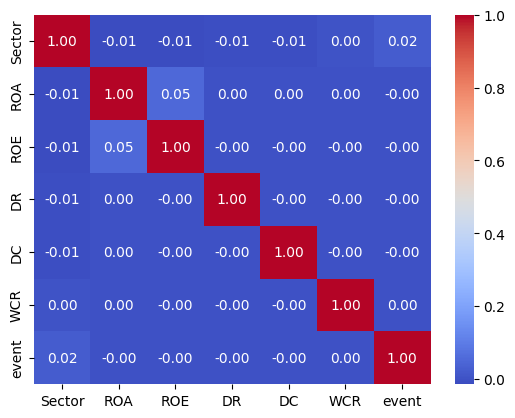

In [9]:
#correlacion
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f") #no hay

In [10]:
#target
X = df.drop('event', axis=1)
y = df['event']

In [11]:
#split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True, random_state = 666, stratify=y)

In [12]:
#desbalanceo
rus = RandomUnderSampler(random_state=1234)
X_train, y_train = rus.fit_resample(X, y)

In [13]:
%%script echo skipping
#normalizar        (regresion logistica + regresion lineal)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

skipping


In [14]:
#estandarización Min-Max  (PARA: Knn, Kmeans, red neuronal)
scaler = MinMaxScaler() # Crea el escalador
scaler.fit(X_train) # Ajusta el escalador solo al conjunto de entrenamiento
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

###Logistic regression

In [15]:
#model
model_lr = LogisticRegression(random_state=666, max_iter=1000)
model_lr.fit(X_train, y_train)

#umbral
umbral = 0.5
y_probs = model_lr.predict_proba(X_test)[:, 1]
preds_lr = (y_probs >= umbral).astype(int) #applicar treshold

print(classification_report(y_test, preds_lr))

#roc
fpr, tpr, thresholds = roc_curve(y_test, preds_lr)
roc_auc = auc(fpr, tpr)
print(roc_auc)

              precision    recall  f1-score   support

         0.0       0.99      0.72      0.83      2763
         1.0       0.04      0.69      0.08        49

    accuracy                           0.72      2812
   macro avg       0.52      0.71      0.46      2812
weighted avg       0.98      0.72      0.82      2812

0.7061497780436822


####optimizar logistic regresion

In [16]:
def grid_lr(X_train, y_train):
    model = LogisticRegression(random_state=666, max_iter=1000)
    class_weight = ['balanced', {0:0.01, 1:0.99}, {0:0.1, 1:0.9}, {0:0.2, 1:0.8}]
    solvers = ['liblinear', 'lbfgs', 'newton-cg', 'sag']
    penalty = ['l2']  # Solo se usa l2
    c_values = [100, 10, 1.0, 0.1, 0.01, 0.001]
    grid = dict(solver=solvers, penalty=penalty, C=c_values, class_weight=class_weight)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv,
                           scoring='roc_auc',error_score='raise')
    grid_result = grid_search.fit(X_train, y_train)
    print(grid_result.best_params_)
    return  grid_result.best_estimator_

In [17]:
best_lr = grid_lr(X_train, y_train)

#umbral
umbral = 0.5
y_probs_lr2 = best_lr.predict_proba(X_test)
preds_lr_2 = (y_probs_lr2[:, 1] >= umbral).astype(int)

print(classification_report(y_test, preds_lr_2))

#roc
fpr, tpr, thresholds = roc_curve(y_test, preds_lr)
roc_auc = auc(fpr, tpr)
print(roc_auc)

{'C': 100, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}
              precision    recall  f1-score   support

         0.0       0.99      0.71      0.83      2763
         1.0       0.04      0.69      0.08        49

    accuracy                           0.71      2812
   macro avg       0.52      0.70      0.45      2812
weighted avg       0.98      0.71      0.81      2812

0.7061497780436822


###Knn

In [18]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)
preds_knn = model_knn.predict(X_test)
print(classification_report(y_test, preds_knn))

#roc
fpr, tpr, thresholds = roc_curve(y_test, preds_knn)
roc_auc = auc(fpr, tpr)
print(roc_auc)

              precision    recall  f1-score   support

         0.0       1.00      0.68      0.81      2763
         1.0       0.05      0.88      0.09        49

    accuracy                           0.68      2812
   macro avg       0.52      0.78      0.45      2812
weighted avg       0.98      0.68      0.80      2812

0.7786235015178711


####optimizar knn

In [19]:
def grid_knn(X_train, y_train):
    model = KNeighborsClassifier()
    n_neighbors = list(range(1, 31, 2))  # Probar valores impares de k hasta 50
    weights = ['uniform', 'distance']
    metric = ['euclidean', 'manhattan', 'minkowski']  # Agregar métrica 'chebyshev'
    p = [1, 2, 3]  # Agregar parámetro p para la métrica de Minkowski
    grid = dict(n_neighbors=n_neighbors, weights=weights, metric=metric, p=p)  # Incluir 'p' en la grilla
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv,
                               scoring='roc_auc',error_score='raise')
    grid_result = grid_search.fit(X_train, y_train)
    print(grid_result.best_estimator_)
    return grid_result.best_estimator_

In [20]:
best_knn = grid_knn(X_train, y_train)
best_knn.fit(X_train, y_train)
preds_knn2 = best_knn.predict(X_test)
print(classification_report(y_test, preds_knn2))

#roc
fpr, tpr, thresholds = roc_curve(y_test, preds_knn2)
roc_auc = auc(fpr, tpr)
print(roc_auc)

KNeighborsClassifier(metric='manhattan', n_neighbors=25, p=1,
                     weights='distance')
              precision    recall  f1-score   support

         0.0       1.00      0.67      0.80      2763
         1.0       0.05      1.00      0.10        49

    accuracy                           0.68      2812
   macro avg       0.53      0.84      0.45      2812
weighted avg       0.98      0.68      0.79      2812

0.8351429605501267


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


###Arboles decision

In [21]:
model_dt = DecisionTreeClassifier(random_state=12)
preds_dt = model_dt.fit(X_train,y_train).predict(X_test)
print(classification_report(y_test,preds_dt))

#roc
fpr, tpr, thresholds = roc_curve(y_test, preds_dt)
roc_auc = auc(fpr, tpr)
print(roc_auc)

              precision    recall  f1-score   support

         0.0       1.00      0.66      0.79      2763
         1.0       0.05      1.00      0.09        49

    accuracy                           0.66      2812
   macro avg       0.52      0.83      0.44      2812
weighted avg       0.98      0.66      0.78      2812

0.8279044516829533


####optimizar arboles decision

In [22]:
def grid_dt(X_train, y_train):
    model = DecisionTreeClassifier(random_state=1000)
    class_weight =  [{0:0.05, 1:0.95}, {0:0.1, 1:0.9}, {0:0.2, 1:0.8}, {0:0.5, 1:0.5}]
    max_depth = None,
    min_samples_leaf = [5, 10, 20, 50, ]
    criterion  = ["gini", "entropy"]
    grid = dict(class_weight=class_weight, max_depth=max_depth, min_samples_leaf=min_samples_leaf, criterion=criterion)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv,
                           scoring='accuracy',error_score='raise')
    grid_result = grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_

In [23]:
best_dt = grid_dt(X_train, y_train)
best_dt.fit(X_train, y_train)
preds_dt2 = best_dt.predict(X_test)
print(classification_report(y_test, preds_dt2))

#roc
fpr, tpr, thresholds = roc_curve(y_test, preds_dt2)
roc_auc = auc(fpr, tpr)
print(roc_auc)

              precision    recall  f1-score   support

         0.0       0.99      0.72      0.83      2763
         1.0       0.04      0.73      0.08        49

    accuracy                           0.72      2812
   macro avg       0.52      0.73      0.46      2812
weighted avg       0.98      0.72      0.82      2812

0.7258340904222709


###RandomForest

In [24]:
model_rf = RandomForestClassifier(random_state = 42)
model_rf.fit(X_train, y_train)
preds_rf = model_rf.predict(X_test)
print(classification_report(y_test, preds_rf))

#roc
fpr, tpr, thresholds = roc_curve(y_test, preds_rf)
roc_auc = auc(fpr, tpr)
print(roc_auc)

              precision    recall  f1-score   support

         0.0       1.00      0.74      0.85      2763
         1.0       0.06      1.00      0.12        49

    accuracy                           0.74      2812
   macro avg       0.53      0.87      0.49      2812
weighted avg       0.98      0.74      0.84      2812

0.8700687658342381


####optimizar random forest

In [25]:
def grid_RandomForest(X_train, y_train):
  model = RandomForestClassifier(random_state=0)
  n_estimators = [100,500]
  criterion = ['gini', 'entropy', 'log_loss']
  min_samples_split = [0.05, 0.1,]
  max_depth = [2,3,4]
  grid = dict(n_estimators = n_estimators, criterion = criterion,
              min_samples_split = min_samples_split, max_depth = max_depth)
  cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
  grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv,
                            scoring='recall',error_score='raise')
  grid_result = grid_search.fit(X_train, y_train)
  return  grid_result.best_estimator_

In [26]:
best_rf = grid_RandomForest(X_train,y_train)
best_rf.fit(X_train, y_train)
preds_rf2 = best_rf.predict(X_test)
print(classification_report(y_test, preds_rf2))

#roc
fpr, tpr, thresholds = roc_curve(y_test, preds_rf2)
roc_auc = auc(fpr, tpr)
print(roc_auc)

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


              precision    recall  f1-score   support

         0.0       0.99      0.72      0.84      2763
         1.0       0.05      0.78      0.09        49

    accuracy                           0.72      2812
   macro avg       0.52      0.75      0.46      2812
weighted avg       0.98      0.72      0.82      2812

0.7489566945127671


###Boosting

####Xgboost

In [27]:
#modelo
model_xgb = XGBClassifier(random_state = 42)
model_xgb.fit(X_train, y_train)
preds_xgb = model_xgb.predict(X_test)
print(classification_report(y_test, preds_xgb))

#roc
fpr, tpr, thresholds = roc_curve(y_test, preds_xgb)
roc_auc = auc(fpr, tpr)
print(roc_auc)

              precision    recall  f1-score   support

         0.0       1.00      0.70      0.82      2763
         1.0       0.06      1.00      0.11        49

    accuracy                           0.70      2812
   macro avg       0.53      0.85      0.46      2812
weighted avg       0.98      0.70      0.81      2812

0.8496199782844733


#####optimizar Xgboost

In [28]:
def grid_XGBoost(X_train, y_train):
  model = XGBClassifier(random_state=0)
  n_estimators = [100, 500]
  learning_rate = [0.01, 0.1, 0.3]
  max_depth = [3, 4, 5]
  subsample = [0.8, 1.0]
  colsample_bytree = [0.8, 1.0]
  gamma = [0, 0.1, 0.2]

  grid = dict(n_estimators=n_estimators, learning_rate=learning_rate,
              max_depth=max_depth, subsample=subsample,
              colsample_bytree=colsample_bytree, gamma=gamma)

  cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
  grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv,
                            scoring='f1',error_score='raise')
  grid_result = grid_search.fit(X_train, y_train)
  print(grid_result.best_score_, grid_result.best_params_)
  return  grid_result.best_estimator_

In [29]:
best_xgb = grid_XGBoost(X_train,y_train)
best_xgb.fit(X_train, y_train)
preds_xgb2 = best_xgb.predict(X_test)
print(classification_report(y_test, preds_xgb2))

#roc
fpr, tpr, thresholds = roc_curve(y_test, preds_xgb2)
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.7574913280801765 {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
              precision    recall  f1-score   support

         0.0       0.99      0.71      0.83      2763
         1.0       0.05      0.80      0.09        49

    accuracy                           0.71      2812
   macro avg       0.52      0.75      0.46      2812
weighted avg       0.98      0.71      0.82      2812

0.7544557453817574


####Adaboost

In [30]:
model_adab = AdaBoostClassifier(random_state=1)
model_adab.fit(X_train, y_train)
preds_adab = model_adab.predict(X_test)
print(classification_report(y_test, preds_adab))

#roc
fpr, tpr, thresholds = roc_curve(y_test, preds_adab)
roc_auc = auc(fpr, tpr)
print(roc_auc)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


              precision    recall  f1-score   support

         0.0       0.99      0.72      0.83      2763
         1.0       0.05      0.80      0.09        49

    accuracy                           0.72      2812
   macro avg       0.52      0.76      0.46      2812
weighted avg       0.98      0.72      0.82      2812

0.7555415217118335


#####optimizar adaboost

In [31]:
def grid_Adaboost(X_train, y_train):
    model = AdaBoostClassifier(random_state=1)
    n_estimators = [2, 15, 35, 50, 70, 100]
    learning_rate = np.linspace(0.01, 1, 10)
    grid = dict(n_estimators=n_estimators, learning_rate=learning_rate)
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
    grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv,
                               scoring='f1', error_score='raise')
    grid_result = grid_search.fit(X_train, y_train)
    print(grid_result.best_score_, grid_result.best_params_)
    return grid_result.best_estimator_

In [32]:
best_adab = grid_Adaboost(X_train,y_train)
best_adab.fit(X_train, y_train)
preds_adab2 = best_adab.predict(X_test)
print(classification_report(y_test, preds_adab2))

#roc
fpr, tpr, thresholds = roc_curve(y_test, preds_adab2)
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.7581040002226687 {'learning_rate': 0.67, 'n_estimators': 15}
              precision    recall  f1-score   support

         0.0       1.00      0.73      0.84      2763
         1.0       0.05      0.80      0.09        49

    accuracy                           0.73      2812
   macro avg       0.52      0.76      0.47      2812
weighted avg       0.98      0.73      0.83      2812

0.7607894406405341


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


###Resultados

| Model              | Accuracy  | Recall | F1-Score | ROC-AUC |
|---------------------|-----------|--------|----------|---------|
| Logistic Regression |     72%   |   71%  |    46%   | 70.61%  |
| Log. Reg. otpimized |     71%   |   70%  |    45%   | 70.61%  |
| KNN                 |     68%   |   78%  |    45%   | 77.86%  |
| KNN optimized       |     68%   |   84%  |    45%   | 83.51%  |
| Decision Tree       |     66%   |   83%  |    44%   | 82.79%  |
| DT optimized        |     72%   |   73%  |    46%   | 72.58%  |
| Random Forest       |     74%   |   87%  |    49%   | 87.01%  |
| Rf optimized        |     72%   |   75%  |    46%   | 74.89%  |
| XGBoost             |     70%   |   85%  |    46%   | 84.96%  |
| XGBoost optimized   |     71%   |   75%  |    46%   | 75.44%  |
| AdaBoost            |     72%   |   76%  |    46%   | 75.55%  |
| AdaBoost optimized  |     73%   |   76%  |    47%   | 76.07%  |
